In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Pendulum dynamics

We consider the following pendulum system with wind $c=[c_x;c_y]\in\mathbb{R}^2$:

$$ml^2\ddot{\theta}-ml\hat{g}\sin\theta = u + \underbrace{f(\theta,\dot{\theta},w)}_{\text{unknown}}$$

where $f$ is given by:
$$F = c_d\cdot\|R\|_2\cdot R,R=c-\begin{bmatrix}l\dot{\theta}\cos\theta \\ -l\dot{\theta}\sin\theta\end{bmatrix}$$
$$f(\theta,\dot{\theta},w) = \underbrace{\vec{l}\times F}_{\text{air drag}} - \underbrace{\alpha\dot{\theta}}_{\text{damping}} + \underbrace{ml(g-\hat{g})\sin\theta}_{\text{gravity mismatch}}$$

and the environment parameter is defined by:
$$w = [c; c_d; g; \alpha] \in\mathbb{R}^5 $$

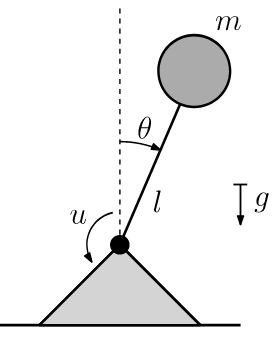

# Pendulum model

In [65]:
class Pendulum:

    def __init__(self, init_theta=0.0, init_dtheta=0.0, duration=20, w=np.array([0,0,0.5,9,0.5]), policy_type='learned'):
        self.duration = duration
        self.policy_type = policy_type
        
        # Pendulum parameters
        self.m = 1.0
        self.l = 0.5
        self.g_hat = 9.81                               
        self.Wind_x = w[0] # [-2,2]
        self.Wind_y = w[1] # [-2,2]
        self.Cd = w[2] # [0,1]
        self.g = w[3] # [8,10]
        self.alpha = w[4] # [0,1]
    
        # States                 
        self.theta = init_theta                   
        self.dtheta = init_dtheta                                                               
        self.state = np.array([self.theta, self.dtheta])
        self.dstate = np.array([0.0, 0.0])
        self.u = 0.0
        
        # Control gain
        self.gain = 1.5
        
        # Noise
        self.u_noise_sigma = 0.1
        self.u_noise = 0.0
        self.a_noise_sigma = 0.05
        self.a_noise = 0.0
        
        # Step
        self.step_size = 1e-2
        self.total_step = 0 
    
        # Fd data
        self.F_d_data = 0.0
        self.F_d_gt = 0.0
    
    # Ground truth unknown dynamics model
    def F_d(self):
        # External wind velocity
        w_x = self.Wind_x
        w_y = self.Wind_y
        v_x = self.l * self.dtheta * np.cos(self.theta)
        v_y = self.l * self.dtheta * np.sin(self.theta)
        R = np.array([w_x - v_x, w_y - v_y])
        F = self.Cd * np.linalg.norm(R) * R
        return self.l * np.sin(self.theta) * F[1] + self.l * np.cos(self.theta) * F[0] \
               - self.alpha * self.dtheta + self.m * self.l * (self.g - self.g_hat) * np.sin(self.theta)
    
    def noise(self):
        if not self.total_step % 10: 
            self.u_noise = np.random.normal(0, self.u_noise_sigma)
            if self.u_noise > 3 * self.u_noise_sigma:
                self.u_noise = 3 * self.u_noise_sigma
            if self.u_noise < -3 * self.u_noise_sigma:
                self.u_noise = -3 * self.u_noise_sigma
        self.a_noise = np.random.normal(0, self.a_noise_sigma)
        
    def controller(self):
        u_feedback = self.m * self.l**2 * (-2 * self.gain * self.dtheta - self.gain**2 * self.theta)
        u_feedforward = -self.m * self.l * self.g_hat * np.sin(self.theta)
        u_random = self.u_noise
        
        # TODO: add the learned model here
        F_d_learned = 0.
        u_learned = -F_d_learned
        
        if self.policy_type == 'learned':
            self.u = u_feedback + u_feedforward + u_random + u_learned
        elif self.policy_type == 'random':
            self.u = u_feedback + u_feedforward + 40 * u_random
        elif self.policy_type == 'oracle':
            self.u = u_feedback + u_feedforward + u_random - self.F_d()
        else:
            print('WARNING! No such policy type')
        
    def dynamics(self):
        self.dstate[0] = self.dtheta
        self.dstate[1] = self.u/(self.m*self.l**2) + self.g_hat/self.l*np.sin(self.theta) + self.F_d()/(self.m*self.l**2)
        self.dstate[1] += self.a_noise
        
    # ODE solver: (4,5) Runge-Kutta
    def process(self):
        self.noise()
        self.controller()
        self.F_d_data = self.F_d() + self.a_noise
        self.F_d_gt = self.F_d()
        
        prev_state = self.state
        
        self.dynamics()
        s1_dstate = self.dstate
        
        self.state = prev_state + 0.5 * self.step_size * s1_dstate
        self.dynamics()
        s2_dstate = self.dstate
        
        self.state = prev_state + 0.5 * self.step_size * s2_dstate
        self.dynamics()
        s3_dstate = self.dstate
        
        self.state = prev_state + self.step_size * s3_dstate
        self.dynamics()
        s4_dstate = self.dstate
        
        self.state = prev_state + 1.0 / 6 * self.step_size * \
                      (s1_dstate + 2 * s2_dstate + 2 * s3_dstate + s4_dstate)
        
        self.total_step += 1
        
        self.dtheta = self.state[1]
        self.theta = self.state[0]
                
    def simulate(self):
        Theta = []
        Theta = np.append(Theta, self.theta)
        Dtheta = []
        Dtheta = np.append(Dtheta, self.dtheta)
        Fd_data = []
        Fd_gt = []
        Control = []
        
        while True:
            self.process()
            Theta = np.append(Theta, self.theta)
            Dtheta = np.append(Dtheta, self.dtheta)
            Control = np.append(Control, self.u)
            Fd_data = np.append(Fd_data, self.F_d_data)
            Fd_gt = np.append(Fd_gt, self.F_d_gt)
            
            # if not self.total_step % int(1 / self.step_size * 1.0):
            #    print('Simulation time: ' + str(self.total_step*self.step_size))

            if self.step_size*self.total_step >= self.duration:
                break

        return Theta[:-1], Dtheta[:-1], Control, Fd_data, Fd_gt

# Simulation

In [66]:
def sim(plot=False, duration=20, w=np.array([0,0,0.5,9,0.5]), policy_type='learned'):
    pendulum = Pendulum(duration=duration, w=w, policy_type=policy_type)

    Theta, Dtheta, Control, Fd_data, Fd_gt = pendulum.simulate()
    time = np.linspace(1e-2, pendulum.duration, int(pendulum.duration*1e2))

    if plot:
        plt.figure(figsize=(14,4))
        plt.subplot(1, 3, 1)
        line1, = plt.plot(time[:], Theta)
        line2, = plt.plot(time[:], Dtheta)
        line3, = plt.plot(time[:], 0*Theta, linestyle='--', color='red')
        plt.xlabel("time/s")
        plt.title("Data: state")
        plt.legend([line1, line2], ["theta", "dtheta"])

        plt.subplot(1, 3, 2)
        plt.plot(time[:], Control)
        plt.xlabel("time/s")
        plt.title("Data: u")

        plt.subplot(1, 3, 3)
        line1, = plt.plot(time[:], Fd_data)
        line2, = plt.plot(time[:], Fd_gt)
        plt.xlabel("time/s")
        plt.legend([line1, line2], ["Fd_data", "Fd_gt"])
        plt.title("Data: Fd gt and observation")
        plt.show()
    
        plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.hist2d(Theta, Dtheta, bins=100)
        plt.title('2D histogram of state')
        
        plt.subplot(1, 2, 2)
        plt.hist(Fd_data, bins=100)
        plt.title('Histogram of Fd_data')
        
    # x = [theta;dtheta] is the state (input), and y = Fd_data is the output    
    return np.vstack((Theta, Dtheta)).transpose(), Fd_data

## Environment parameter ranges

Wind_x = `w[0]` $\in$ [-2,2] 

Wind_y = `w[1]` $\in$ [-2,2]

$C_d$     = `w[2]` $\in$ [0,1]

$g$      = `w[3]` $\in$ [8,10]

$\alpha$  = `w[4]` $\in$ [0,1]

`w` = [0, 0, 0, 9.81, 0] mean there is no uncertainty ($f=0$)

## Policy types

`policy_type='learned'`: using the learned $f$ in the policy

`policy_type='oracle'`: using the true $f$ in the policy

`policy_type='random'`: using random $u$

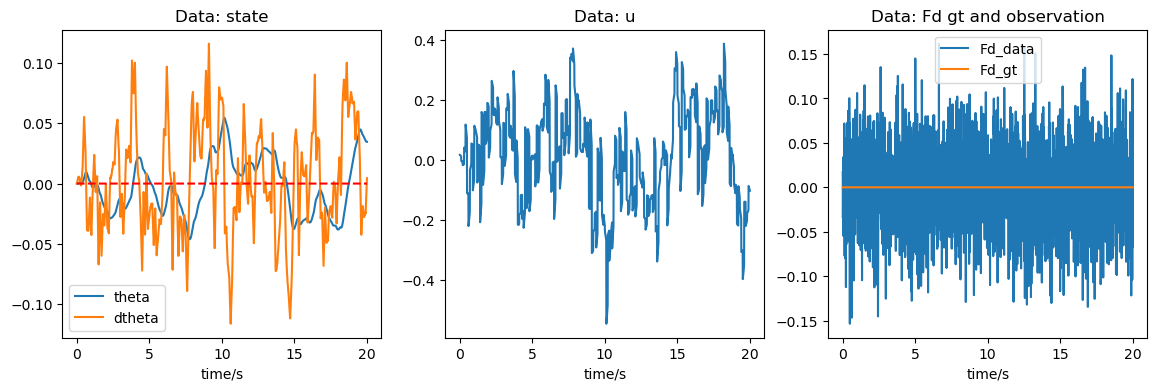

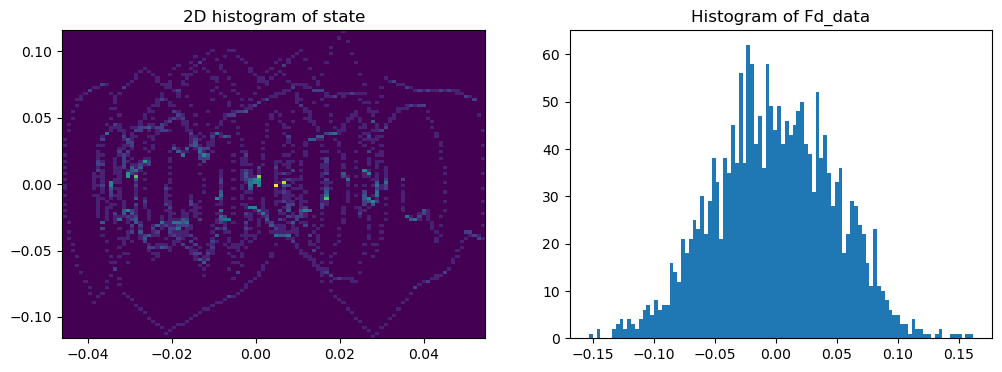

In [54]:
x, y = sim(plot=True, duration=20, w=np.array([0., 0., 0., 9.81, 0.]), policy_type='learned')

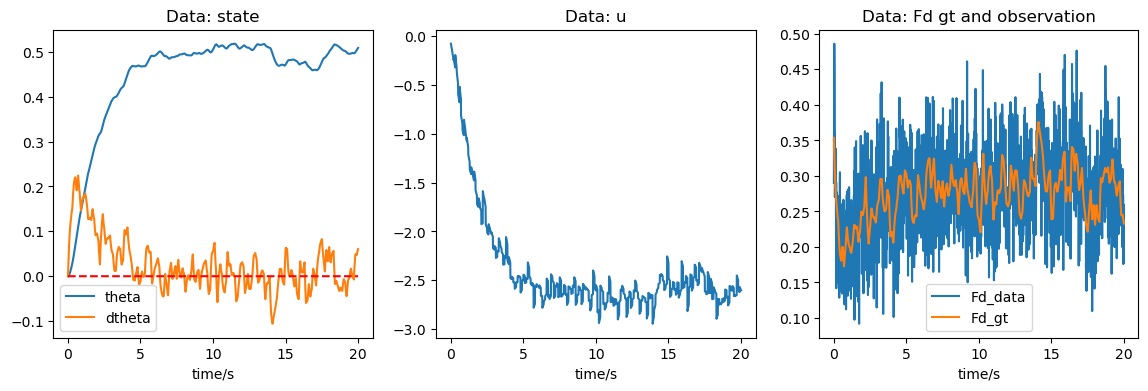

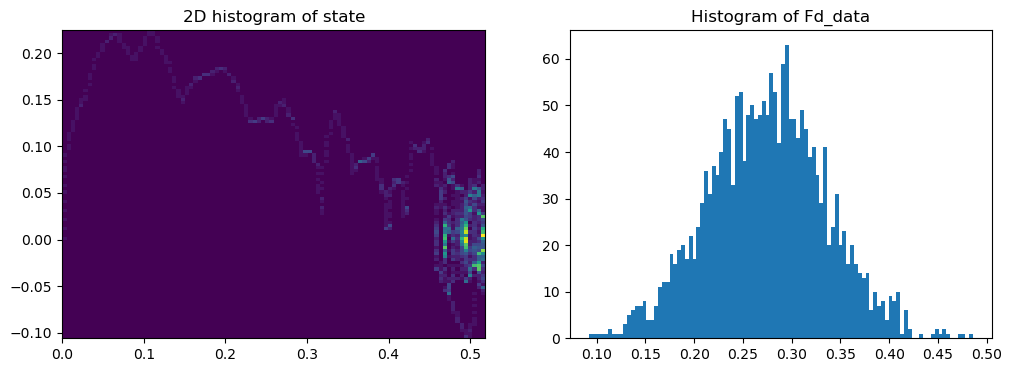

In [55]:
x, y = sim(plot=True, duration=20, w=np.array([1, 1, 0.5, 9., 0.5]), policy_type='learned')

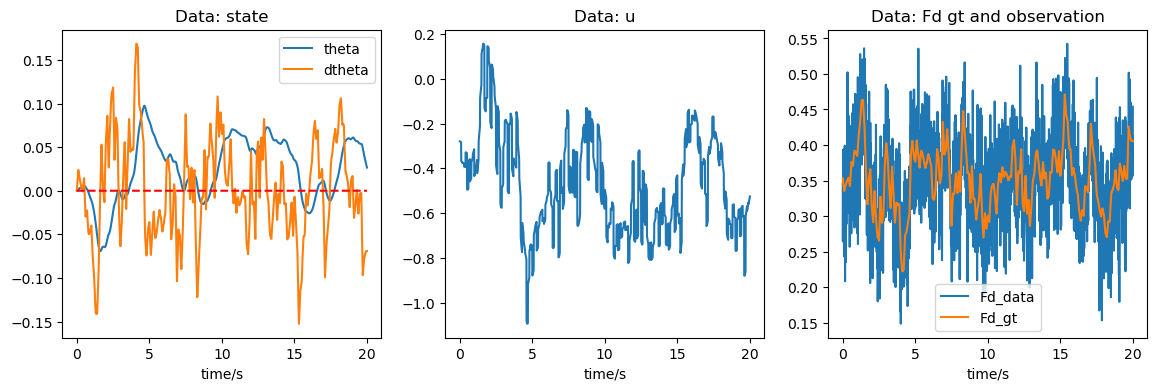

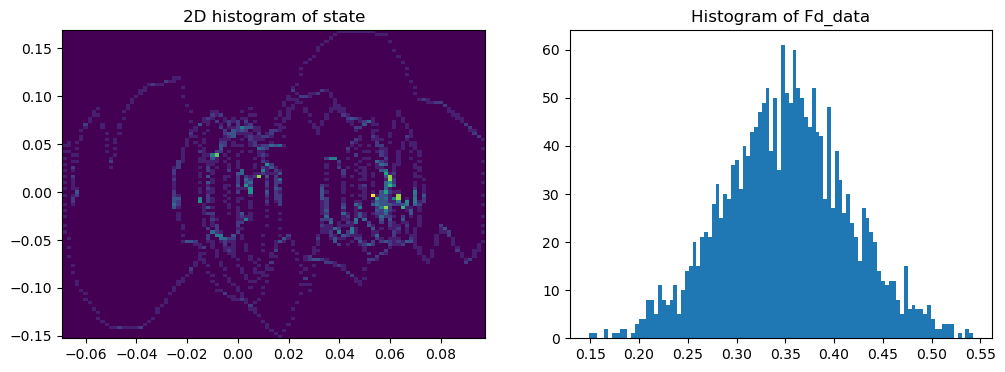

In [56]:
x, y = sim(plot=True, duration=20, w=np.array([1, 1, 0.5, 9., 0.5]), policy_type='oracle')

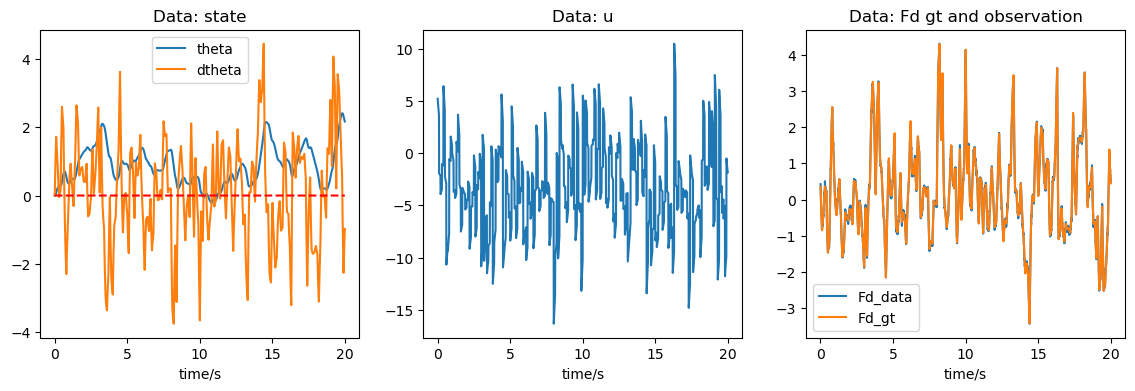

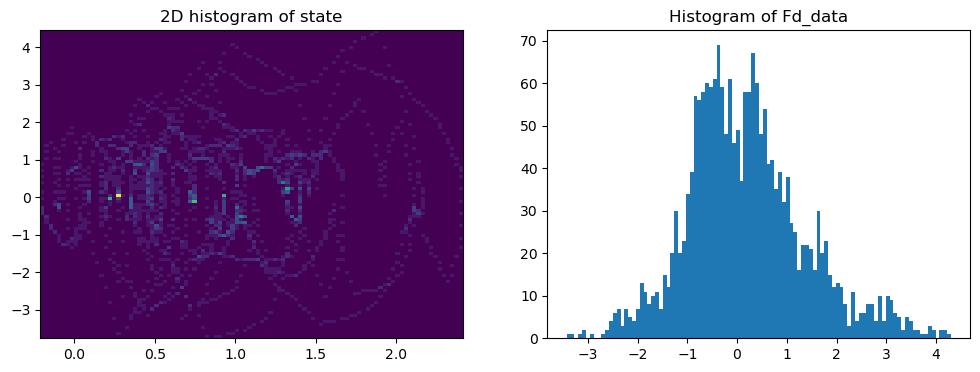

In [67]:
x, y = sim(plot=True, duration=20, w=np.array([1, 1, 0.5, 9., 0.5]), policy_type='random')